# Levenberg-Marquardt algorithm
### The following notebook contains a simple implementation of the Levenberg-Marquardt algorith also known as Damped Least Squares. The example presented in this notebook is related to a widely used tool in petroleum engineering known as Declination Curves.

#### A brief explanation about declination curves
Declination curves are used in petroleum engineering to analyze and estimate future rates in oil and gas wells. The oil and gas production decline is usually a product of a drop in reservoir pressure or changes in the relative volumes at reservoir conditions. The concept of a declination curve is simple: use the past historical production to fit a curve and then use this curve to predict future behaviour. With this methodology, the main assumption is that future oil and gas production will follow the same declination trend that has been followed before which is not always the case for all wells.

In spite of its simplicity, the declination curves analysis is widely known and used in the petroleum engineering community as a way of obtaining a quick estimation of future produced volumes. There are three main types of declination curves as proposed by Arps in 1945: exponential, hyperbolic and harmonic. All these expressions allow to relate the rate with the time elapsed from the initial rate measurement to a particular point in the future. The parameters also depend on the units that are used to express time and rate.

<img src=DC.png width="400" />

The exponential curve can be linearized in order to find the value of _d_. However, both the exponential and harmonic curves are non-linear expressions. Numerous software and reservoir engineering packages allow users to easily find the best parameters for each declination curve and obtain multiple forecasts. However, this is a good example of a practical application of the damped least squares method. The rest of this notebook contains a step-by-step explation of how to apply this algorithm to adjust an hyperbolic and harmonic declination curve.

Additional information about declination curves can be found in:


* Arps, J.J. Analysis of decline curves. Trans. AIME 1945, 160, 228–247. 

* Fetkovich, M. J., Fetkovich, E. J., & Fetkovich, M. D. 1996. Useful Concepts for Decline Curve Forecasting, Reserve Estimation, and Analysis. Society of Petroleum Engineers.

* Paryani, M.; Ahmadi, M.; Awoleke, O.; Hanks, C. Decline Curve Analysis: A Comparative Study of Proposed
Models Using Improved Residual Functions. J. Pet. Environ. Biotechnol. 2018, 9, 362.

* [Production forecasting decline curve analysis](https://petrowiki.spe.org/Production_forecasting_decline_curve_analysis). Petrowiki

## Implementation of the Levenberg-Marquardt algorithm

#### Importing the libraries

In [1]:
import numpy as np #NumPy https://numpy.org/
import pandas as pd #Pandas https://pandas.pydata.org/
import matplotlib.pyplot as plt #Matplotlib https://matplotlib.org/
from scipy.optimize import curve_fit #https://www.scipy.org/
import math
%matplotlib inline

#### Loading and plotting the data

Text(0, 0.5, 'Oil rate [m3/day]')

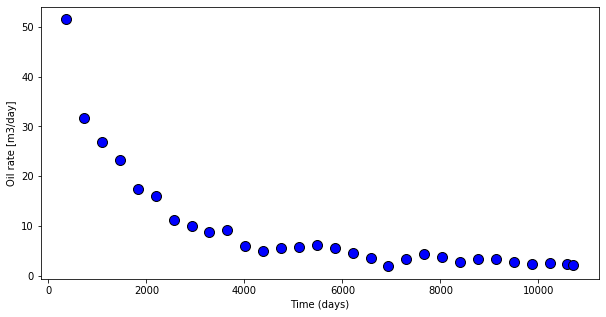

In [2]:
#Load the data
df=pd.read_csv('well.csv') #This file contains the rate (m^3/day) vs time (days) for an oil well
x = df.loc[:,'x']
y = df.loc[:,'y']
#Plot the data
plt.figure(figsize=(10,5))
plt.scatter(x=x, y=y,facecolor='blue',edgecolor='black',s=100,zorder=10)
plt.xlabel('Time (days)')
plt.ylabel('Oil rate [m3/day]')

#### Harmonic and Hyperbolic functions

In [3]:
#Define both functions. The input is:
     #The independent variable x (time)
     #The parameters (a1,a2) 
     #The initial rate that is fixed

def Harm(x,a1,qi):
    y=qi/(1+a1*x)
    return y

def Hyperb(x,a1,a2,qi):
    y=qi/np.power(1+a1*a2*x,1/a2)
    return y


#### Define a function to calculate the new parameters using a Levenberg-Marquardt step <img src=LM_Step.png width="300" />

In [4]:
def LevMarq(x,y_real,qi,lamb,model,a1=1,a2=1):
    
    if model=='Harmonic':
        J=np.zeros((x.shape[0],2))
        for i in range(J.shape[0]):
            J[i,0]=-qi*x[i]/np.power(1+a1*x[i],2) #Calculate Jacobian
            J[i,1]=1/(1+a1*x[i])
        J2=np.dot(np.linalg.inv(np.dot(np.transpose(J),J)+lamb*np.identity(J.shape[1])),np.transpose(J)) #Calculate J2=(J^T.J+lamb.I)^-1.J^T
        delta=np.dot(J2,Harm(x,a1,qi)-y_real)
        a1=a1-delta[0] #New value for parameter a1
        qi=qi-delta[1] #New value for parameter qi
    
    if model=='Hyperbolic':
        J=np.zeros((x.shape[0],3))
        for i in range(J.shape[0]):
            J[i,0]=-qi/a2*np.power(1+a2*a1*x[i],-1/a2-1)*a2*x[i] #Calculate Jacobian
            J[i,1]=(qi*(np.log(a1*a2*x[i]+1)/(a2*a2)-a1*x[i]/(a2*a1*x[i]*a2+a2)))/np.power(a1*a2*x[i]+1,1/a2)
            J[i,2]=1/np.power(1+a1*a2*x[i],1/a2)                                                  
                                                              
        J2=np.dot(np.linalg.inv(np.dot(np.transpose(J),J)+lamb*np.identity(J.shape[1])),np.transpose(J)) #Calculate J2=(J^T.J+lamb.I)^-1.J^T
        delta=np.dot(J2,Hyperb(x,a1,a2,qi)-y_real)
        a1=a1-delta[0] #New value for parameter a1
        a2=a2-delta[1] #New value for parameter a2
        qi=qi-delta[2] #New value for parameter qi                                                      
        
    return a1,a2,qi


#### Define a function that runs the Levenberg-Marquardt algorithm

In [5]:
#Define a function that runs the Marquardt-Levenberg algorithm
#INPUT:
 #Independent variable x (time)
 #Real values y (oil rate)
 #Model: Harmonic or Hyperbolic
 #lamb: initial value for lambda
 #qi: initial rate
 #a1,a2: initial guess for the parameters
 #Iterations: maximum number of iterations
    
def Adjust(x,y_real,model,lamb,qi=1,a1=1,a2=1,iterations=150): 
    a1_r=a1 #These values are saved for plotting purposes
    a2_r=a2
    qi_r=qi
    
    #Calculate the rate according to the model selected
    if model=='Harmonic':
        y_model=Harm(x,a1_r,qi)
    else:
        y_model=Hyperb(x,a1_r,a2_r,qi)
    
    #Calculate the sum of squared residuals
    r2=np.power(y_model-y_real,2)
    s1=np.sqrt(np.sum(r2))
    
    print("The first S is: ",s1)
    a1n=a1
    a2n=a2
    qin=qi
    s=1e30
    c=1
    print("The first Lambda is:",lamb)
    
        
    for c in range(iterations):
        if model=='Harmonic':
            a1=a1n
            qi=qin
            a1n,a2n,qin=LevMarq(x,y_real,qi,lamb,'Harmonic',a1n)
            y_model=Harm(x,a1n,qi)
        else:
            a1=a1n
            a2=a2n
            qi=qin
            a1n,a2n,qin=LevMarq(x,y_real,qi,lamb,'Hyperbolic',a1n,a2n)
            y_model=Hyperb(x,a1n,a2n,qi)
        r2=np.power(y_model-y_real,2)
        s1=np.sqrt(np.sum(r2))
        print('Iteration=%d, Sum=%f, a1=%f, a2=%f, qi=%f, Lambda=%f' % (c,s1,a1n,a2n,qin,lamb))
        
        if abs(s1-s)<1E-10:
            c=c+1
        else:
            c=1
        if s1<0.0001 or c>10:
            print('A correct value has been found: S=%f, a1=%f, a2=%f, qi=%f' % (s1,a1,a2,qi))
            break

        if s1>s or lamb<1E-4:
            lamb=lamb*2
            print('Increasing lambda',lamb)
            a1n=a1
            a2n=a2
            qin=qi
        else:
            lamb=lamb/3
            print('Decreasing lambda',lamb)
            s=s1
                    
    #Plot
    plt.figure(figsize=(15,5))
    if model=='Harmonic':
        plt.plot(x, Harm(x,a1_r,qi),color='red',label='Initial values', lw=5,zorder=0)
        plt.plot(x, Harm(x,a1n,qi),color='green',label='Adjusted values', lw=5,zorder=5)
    else:
        plt.plot(x, Hyperb(x,a1_r,a2_r,qi),color='red',label='Initial values', lw=5,zorder=0)
        plt.plot(x, Hyperb(x,a1n,a2n,qi),color='green',label='Adjusted values', lw=5,zorder=5)    
    plt.scatter(x=x, y=y,facecolor='none',edgecolor='black',s=100,zorder=10)
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Oil rate [m3/day]')
    plt.rc('font', size=8)          # controls default text sizes
    plt.rc('axes', titlesize=20)     # fontsize of the axes title
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
    plt.rc('legend', fontsize=14)    # legend fontsize
    plt.rc('figure', titlesize=14)  # fontsize of the figure title
    plt.grid(True)
    plt.show()
    return a1,a2,qi

#### 1) Harmonic model:
For this case let's use a first parameter value of 50 and a lambda of 10

The first S is:  78.7312539720652
The first Lambda is: 10
Iteration=0, Sum=78.731254, a1=49.999989, a2=1.000000, qi=1.000534, Lambda=10.000000
Decreasing lambda 3.3333333333333335
Iteration=1, Sum=78.731254, a1=49.999957, a2=1.000000, qi=1.002135, Lambda=3.333333
Decreasing lambda 1.1111111111111112
Iteration=2, Sum=78.731254, a1=49.999861, a2=1.000000, qi=1.006940, Lambda=1.111111
Decreasing lambda 0.3703703703703704
Iteration=3, Sum=78.731254, a1=49.999571, a2=1.000000, qi=1.021354, Lambda=0.370370
Decreasing lambda 0.1234567901234568
Iteration=4, Sum=78.731253, a1=49.998687, a2=1.000000, qi=1.064596, Lambda=0.123457
Decreasing lambda 0.0411522633744856
Iteration=5, Sum=78.731250, a1=49.995925, a2=1.000000, qi=1.194325, Lambda=0.041152
Decreasing lambda 0.013717421124828532
Iteration=6, Sum=78.731241, a1=49.986628, a2=1.000000, qi=1.583532, Lambda=0.013717
Decreasing lambda 0.004572473708276177
Iteration=7, Sum=78.731214, a1=49.949633, a2=1.000000, qi=2.751371, Lambda=0.004572
Decrea

Iteration=89, Sum=11.333831, a1=0.002606, a2=1.000000, qi=95.463160, Lambda=0.100017
Increasing lambda 0.20003378172972971
Iteration=90, Sum=10.152921, a1=0.002482, a2=1.000000, qi=92.214926, Lambda=0.200034
Decreasing lambda 0.06667792724324324
Iteration=91, Sum=10.686572, a1=0.002791, a2=1.000000, qi=100.383729, Lambda=0.066678
Increasing lambda 0.13335585448648649
Iteration=92, Sum=9.589782, a1=0.002672, a2=1.000000, qi=97.297236, Lambda=0.133356
Decreasing lambda 0.044451951495495495
Iteration=93, Sum=9.971887, a1=0.002966, a2=1.000000, qi=104.965853, Lambda=0.044452
Increasing lambda 0.08890390299099099
Iteration=94, Sum=9.062951, a1=0.002860, a2=1.000000, qi=102.234086, Lambda=0.088904
Decreasing lambda 0.02963463433033033
Iteration=95, Sum=9.252572, a1=0.003119, a2=1.000000, qi=108.930555, Lambda=0.029635
Increasing lambda 0.05926926866066066
Iteration=96, Sum=8.597259, a1=0.003032, a2=1.000000, qi=106.711720, Lambda=0.059269
Decreasing lambda 0.019756422886886886
Iteration=97, 

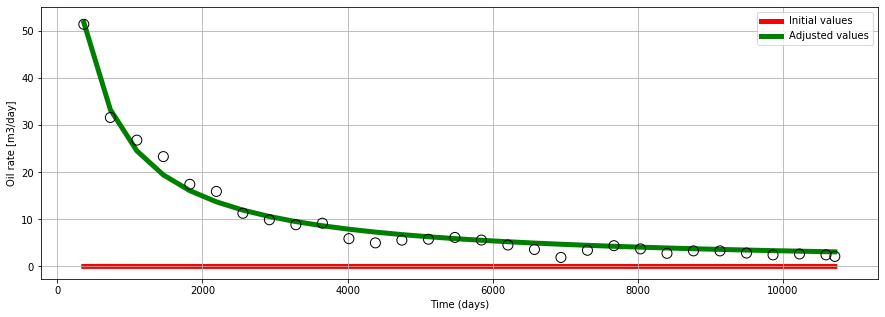

(0.0034122742628259167, 1, 116.400560831955)

In [6]:
#   (x, y_real, model, lamb, qi, a1=1, a2=1, iterations=150):
Adjust(x,y,'Harmonic',10,qi=1,a1=50)

The plot shows the difference between the model using the initial values and the adjusted model. Note also the difference between the initial S (square root of the sum of squared residuals) and the final S.
It is important to remember that the performance of this method is highly dependable on:
* The initial estimation of a1 and qi
* The initial value of Lambda
We can use the function curve_fit from SciPy to compare our results:

In [7]:
popt, pcov = curve_fit(Harm, x, y, method='lm')
print('The adjusted values are: a1 = %f, qi=%f' % (popt[0],popt[1]))
#print(popt[0],popt[1],popt[2])

The adjusted values are: a1 = 0.003412, qi=116.400747


In this case both parameters are the same

#### 2) Hyperbolic model:
For this case let's use a first parameter value (a1) of 0.01, a second parameter value (a2) of 0.1, a qi of 15 and and a lambda of 1E6

The first S is:  78.26754986110093
The first Lambda is: 1000000.0
Iteration=0, Sum=48.841955, a1=0.000258, a2=0.100175, qi=15.000002, Lambda=1000000.000000
Decreasing lambda 333333.3333333333
Iteration=1, Sum=51.081171, a1=0.000063, a2=0.099805, qi=15.000180, Lambda=333333.333333
Increasing lambda 666666.6666666666
Iteration=2, Sum=51.076580, a1=0.000063, a2=0.099990, qi=15.000091, Lambda=666666.666667
Increasing lambda 1333333.3333333333
Iteration=3, Sum=51.072644, a1=0.000064, a2=0.100082, qi=15.000047, Lambda=1333333.333333
Increasing lambda 2666666.6666666665
Iteration=4, Sum=51.067400, a1=0.000064, a2=0.100129, qi=15.000024, Lambda=2666666.666667
Increasing lambda 5333333.333333333
Iteration=5, Sum=51.058234, a1=0.000064, a2=0.100152, qi=15.000013, Lambda=5333333.333333
Increasing lambda 10666666.666666666
Iteration=6, Sum=51.040611, a1=0.000064, a2=0.100163, qi=15.000008, Lambda=10666666.666667
Increasing lambda 21333333.333333332
Iteration=7, Sum=51.005901, a1=0.000064, a2=0.100

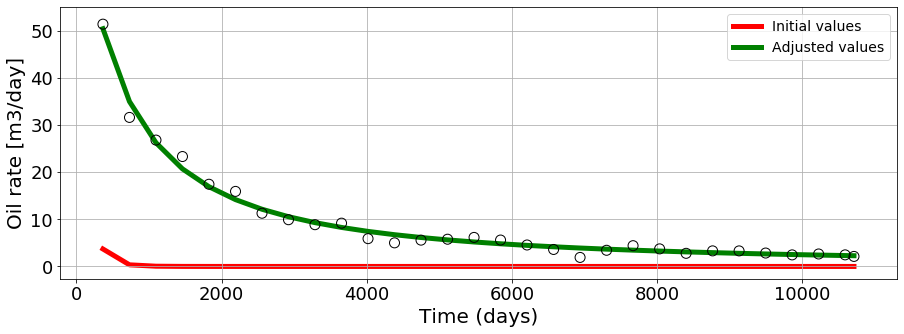

(0.0016546682816793207, 0.7336909923318288, 83.21849754011629)

In [8]:
#   (x, y_real, model, lamb, qi, a1=1, a2=1, iterations=150):
Adjust(x,y,'Hyperbolic',1E6,qi=15,a1=0.01,a2=0.1)

This is an example where the selection of the initial guess for the parameters is considerably important. This algorithm won't converge (or at least it will take many iterations) depending on how far our initial estimations are from the solution. It is important to have a good idea of the order of magnitude of each of these parameters before running the algorithm.

Regarding the value of lambda, note how this time we have started with a very large number of Lambda so the first steps in the algorithms are Gradient Descent steps.

We can also compare these results with the curve_fit function

In [9]:
popt, pcov = curve_fit(Hyperb, x, y, method='lm')
print('The adjusted values are: a1 = %f, a2=%f, qi=%f' % (popt[0],popt[1],popt[2]))
#print(popt[0],popt[1],popt[2])

The adjusted values are: a1 = 0.001655, a2=0.733687, qi=83.218114
